In [7]:
import xarray as xr
import numpy as np 
import datetime
import pyresample 
import metpy
import pandas as pd
import matplotlib.pyplot as plt
import os, glob

def get_XYpositions(filename, lons, lats):
    
    fh = xr.open_dataset(filename)
    x   = np.linspace(0, fh.lat_rho.values.shape[1]-1, fh.lat_rho.values.shape[1])
    y   = np.linspace(0, fh.lat_rho.values.shape[0]-1, fh.lat_rho.values.shape[0])
    xi  = np.zeros_like(fh.lon_rho.values)
    yi  = np.zeros([fh.lon_rho.values.shape[1], fh.lon_rho.values.shape[0]])
    xi[:,:] = x
    yi[:,:] = y
    yi  = np.swapaxes(yi, 1, 0)

    # First I define the wet points of the field as the lon,lat values with mask_rho==1 
    sea_def = pyresample.geometry.SwathDefinition(lons= fh.lon_rho.values[np.where(fh.mask_rho)], lats = fh.lat_rho.values[np.where(fh.mask_rho)])

    # Second, the full grid definiton (our target domain):
    orig_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

    # Then I fill the temperature field by the nearest neighbour approace.
    # Note that only wet points are used as input. 

    # The radius of influence sets a limit (in meters) for how far away a true value can be from the point that will be filled

    ypos = pyresample.kd_tree.resample_nearest(sea_def, yi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)

    xpos = pyresample.kd_tree.resample_nearest(sea_def, xi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)
    return np.array([int(x) for x in xpos]), np.array([int(y) for y in ypos])


In [19]:

locations = {'Ekofisk': {'lat': 56 + 32/60, 'lon': 3 + 12/60}}
dtg = datetime.datetime.now() - datetime.timedelta(days =0 )

# Generic Filename:
path = 'https://thredds.met.no/thredds/dodsC/sea_norshelf_files/{}/norshelf_qck_an_{}T00Z.nc'
path = "https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_{}T00Z.nc"
# Calculate  X, Y positions in the dictionary "locations": 

gridfile = '/lustre/storeB/project/fou/hi/oper/norshelf/static_inputfiles/norshelf_2.4_vert_grd.nc'

for loc, coord in locations.items():
    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(gridfile, np.array([coord['lon']]), np.array([coord['lat']])) 
  


In [20]:
import xroms 
# To get the depth of the sigma layers, the package xroms can be helpful
ds = xr.open_dataset(gridfile)
ds.zeta.values[:] = 0 # s-layers are slighty displaced in the vertical with movements in the free-surface. Set free surface (zeta) to zero to get the vertical coordinate with respect to no displacement of the free surface. 

# Get vertical information: 
ds, xgrid = xroms.roms_dataset(ds, include_3D_metrics= False)
ds = ds.isel(xi_rho = locations[loc]['X'], eta_rho = locations[loc]['Y']  )


In [22]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, s_rho: 42, s_w: 43, ocean_time: 1, eta_rho: 1,
                    xi_u: 900, eta_v: 350, xi_rho: 1, boundary: 4)
Coordinates: (12/15)
    lat_psi        (eta_v, xi_u) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    lat_v          (eta_v, xi_rho) float64 ...
    lon_psi        (eta_v, xi_u) float64 ...
    lon_rho        (eta_rho, xi_rho) float64 ...
    ...             ...
  * s_rho          (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w            (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
  * xi_u           (xi_u) int64 0 1 2 3 4 5 6 7 ... 893 894 895 896 897 898 899
  * xi_rho         (xi_rho) int64 12
  * eta_rho        (eta_rho) int64 147
  * eta_v          (eta_v) int64 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
Dimensions without coordinates: tracer, boundary
Data variables: (12/90)
    Akt_bak        (tracer) float64 ...
    Akv_bak        float64 ...
    Cs_r           (s_rho) float64 ...
    Cs_w           (s_w) float64 ...
    DU_avg1        (ocean_time, eta_rho, xi_u) float64 ...
    DU_avg2        (ocean_time, eta_rho, xi_u) float64 ...
    ...             ...
    dx_psi         (eta_v, xi_u) float64 1.168e+03 2.336e+03 ... 3.153e+03
    dy             (eta_rho, xi_rho) float64 2.352e+03
    dy_u           (eta_rho, xi_u) float64 2.349e+03 2.349e+03 ... 2.503e+03
    dy_v           (eta_v, xi_rho) float64 1.168e+03 2.336e+03 ... 2.961e+03
    dy_psi         (eta_v, xi_u) float64 1.166e+03 1.167e+03 ... 3.153e+03
    dA             (eta_rho, xi_rho) float64 5.538e+06
Attributes: (12/38)
    file:                      /work/jro005/Run_stability/ocean_his.nc
    format:                    netCDF-4/HDF5 file
    Conventions:               CF-1.4
    type:                      ROMS/TOMS history file
    title:                     MET Var-EPS (4km)
    rst_file:                  /work/jro005/Run_stability/ocean_rst.nc
    ...                        ...
    Created:                   2016-01-12T13:13:24.215619
    date:                      2015-01-14
    gridname:                  norseas_800m
    Institution:               Institute of Marine Research
    sponge:                    14-Dec-2015 created with /disk1/ROMS-matlab/gr...
    nco_openmp_thread_number:  1

In [35]:
len(ds["eta_v"])

350

In [23]:
for s in range(ds.s_rho.size):
    print('Depth of layer {}: {} meters'.format(s, np.round(ds.s_rho.values.ravel()[s], 1)))

Depth of layer 0: -1.0 meters
Depth of layer 1: -1.0 meters
Depth of layer 2: -0.9 meters
Depth of layer 3: -0.9 meters
Depth of layer 4: -0.9 meters
Depth of layer 5: -0.9 meters
Depth of layer 6: -0.8 meters
Depth of layer 7: -0.8 meters
Depth of layer 8: -0.8 meters
Depth of layer 9: -0.8 meters
Depth of layer 10: -0.8 meters
Depth of layer 11: -0.7 meters
Depth of layer 12: -0.7 meters
Depth of layer 13: -0.7 meters
Depth of layer 14: -0.7 meters
Depth of layer 15: -0.6 meters
Depth of layer 16: -0.6 meters
Depth of layer 17: -0.6 meters
Depth of layer 18: -0.6 meters
Depth of layer 19: -0.5 meters
Depth of layer 20: -0.5 meters
Depth of layer 21: -0.5 meters
Depth of layer 22: -0.5 meters
Depth of layer 23: -0.4 meters
Depth of layer 24: -0.4 meters
Depth of layer 25: -0.4 meters
Depth of layer 26: -0.4 meters
Depth of layer 27: -0.3 meters
Depth of layer 28: -0.3 meters
Depth of layer 29: -0.3 meters
Depth of layer 30: -0.3 meters
Depth of layer 31: -0.2 meters
Depth of layer 32:

In [10]:
dtg_start = datetime.datetime(2024, 6,1 ) 
dtg_stop  = datetime.datetime.now()

loc = 'Ekofisk'
df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] ,'TEMP[degC]' :[]})
 
# Loop over the days to extract data for
while dtg_start <= dtg_stop:

    # Correct file name for the current day:
    workonfile = path.format( dtg_start.strftime('%Y/%m'),  dtg_start.strftime('%Y%m%d'))
    
    print('Working on {}, {}'.format(dtg_start, workonfile))

    # Open for read. Do within try/except as some files may be missing due to interruptions in the operational service.
    try:
        with xr.open_dataset(workonfile) as ds:
            # Selcect current variables: 
            ds = ds.get(['u_eastward', 'v_northward', 'temp'])
            # Choose the vertical layer closest to the bottom:
            ds = ds.isel(s_rho = 1 )
            # Choose your selectet x,y locations 
            tmp = ds.isel(xi_rho = locations[loc]['X'], eta_rho = locations[loc]['Y'])

            # Calculate speed/direction:
            cspd = np.squeeze(metpy.calc.wind_speed(tmp.u_eastward.values*metpy.units.units('m/s') , tmp.v_northward*metpy.units.units('m/s')))
            cdir = np.squeeze(metpy.calc.wind_direction(tmp.u_eastward.values*metpy.units.units('m/s') , tmp.v_northward*metpy.units.units('m/s'), convention = 'to'))

            # Store information in a pandas dataframe:
            df = pd.concat([df, pd.DataFrame({'SITE': [loc]*len(cspd) , 'LAT': [np.round(coord['lat'],3)] *len(cspd), 'LONG': [np.round(coord['lon'],3)] *len(cspd), 'TIME': [dtg_start.strftime('%Y-%m-%dT00:00:00Z')]*len(cspd) , 'PROG': [t.replace('T', ' ') + ' UTC' for t in np.datetime_as_string(tmp.ocean_time, unit = 's')], 'CD[deg]':np.round(cdir,1), 'CV[m/s]': np.round(cspd,5), 'TEMP[degC]': np.round(tmp.temp.values.squeeze(), 5)  })])

    except:
        pass
    # Update dtg_start to ensure that next iteration of while loop  processes data for the next day
    dtg_start += datetime.timedelta(days = 1)
df.to_csv('{}.csv'.format(loc), header = 'SITE,LAT,LONG,TIME,PROG,CD[deg],CV[m/s],TEMP[degC]' , mode = 'a', index = False)
  

Working on 2024-06-01 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-02 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-03 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-04 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-05 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^ xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <head> <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"> <title>TDS - Error report</title> <link rel="stylesheet" href="/thredds/tds.css" type="text/css"/> </head> <body> <h1>HTTP Status 404 - Not Found</h1> <HR size="1" noshade="noshade"> <p><b>Status</b> 404 - Not Found</p> <HR size="1" noshade="noshade"> <h3>THREDDS Data Server Version 4.6 -- <a href='https://www.unidata.ucar.edu/software/thredds/v4.6/tds/TDS.html'>Documentation</a></h3> </body></html>
syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^ xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <head> <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"> <title>TDS - Error report</title> <link rel="stylesheet" href="/thredds/tds.css" type="text/css"/> </head> <body> <h1>H

Working on 2024-06-06 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-07 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-08 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-09 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-10 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-11 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-12 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06T00Z.nc
Working on 2024-06-13 00:00:00, https://thredds.met.no/thredds/catalog/sea_norshelf_files/2024/norshelf_qck_an_2024/06

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^ xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <head> <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"> <title>TDS - Error report</title> <link rel="stylesheet" href="/thredds/tds.css" type="text/css"/> </head> <body> <h1>HTTP Status 404 - Not Found</h1> <HR size="1" noshade="noshade"> <p><b>Status</b> 404 - Not Found</p> <HR size="1" noshade="noshade"> <h3>THREDDS Data Server Version 4.6 -- <a href='https://www.unidata.ucar.edu/software/thredds/v4.6/tds/TDS.html'>Documentation</a></h3> </body></html>
syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^ xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <head> <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"> <title>TDS - Error report</title> <link rel="stylesheet" href="/thredds/tds.css" type="text/css"/> </head> <body> <h1>H

In [26]:
df_lowest = df.copy()

In [27]:
df.head(48)

,SITE,LAT,LONG,TIME,PROG,CD[deg],CV[m/s],TEMP[degC]


In [28]:
# Du kan se innholdet i dataframe slik: 
df.head(20) # hvor tallet indikerer hvor mange linjer du skal se på:


,SITE,LAT,LONG,TIME,PROG,CD[deg],CV[m/s],TEMP[degC]


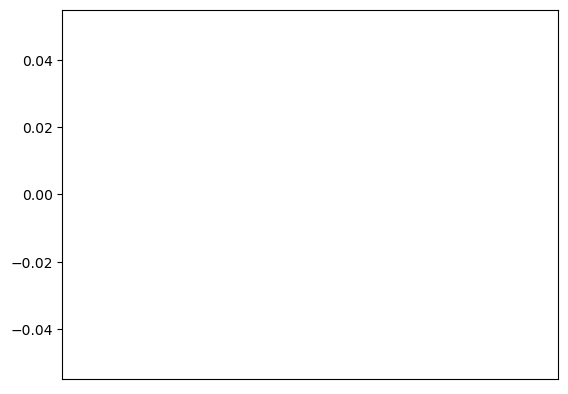

In [29]:

plt.plot(df_lowest.PROG, df_lowest['CV[m/s]'])
plt.xticks(df_lowest.PROG[0::24*15]);
plt.plot(df.PROG, df['CV[m/s]'])
plt.xticks(df.PROG[0::24*15]);

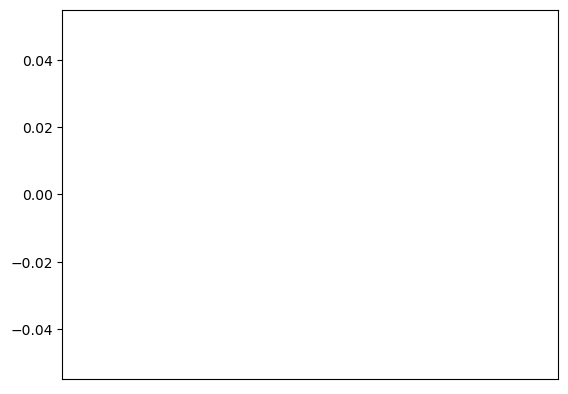

In [30]:

plt.plot(df_lowest.PROG, df['CV[m/s]'])
plt.xticks(df_lowest.PROG[0::24*15]);

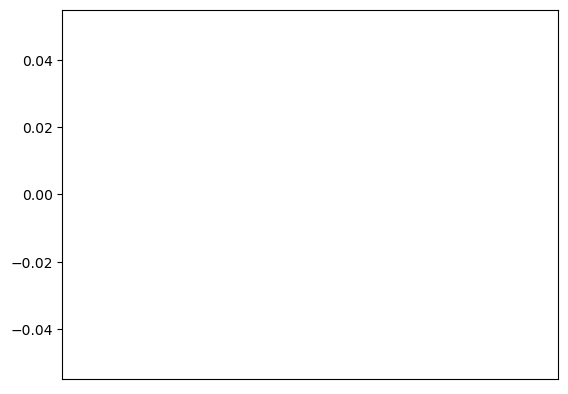

In [31]:
plt.plot(df_lowest.PROG, df_lowest['CD[deg]'])
plt.xticks(df_lowest.PROG[0::24*15]);
plt.plot(df.PROG, df['CD[deg]'])
plt.xticks(df.PROG[0::24*15]);

In [32]:
import windrose  
ax = windrose.WindroseAxes.from_ax()
ax.bar(df['CD[deg]'], df['CV[m/s]'], opening=0.8, edgecolor='white', bins=np.arange(0, 0.3, 0.05))
ax.set_legend()

ModuleNotFoundError: No module named 'windrose'

In [33]:
import sys

In [34]:
sys.version

'3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) \n[GCC 10.3.0]'